## Part 2: Evaluating One Particular Type of Alternative Data (Social Media Data)

### No. 5: Importing and Structuring Reddit Data into Useful Data Structures

In [21]:
!pip install praw
import praw
import pandas as pd
from datetime import datetime

# Reddit API credentials
reddit = praw.Reddit(client_id='p7UMF3D4H3VFZ-Xe2E3FrA',
                     client_secret='jQQR4I7IDTOo3hg7CA5ty-oGVvmFIw',
                     user_agent='DataBot by u/Deep_Engineering_773')

# Define subreddits and limits
subreddits = ['investing', 'stocks', 'wallstreetbets']
post_limit = 500
comment_limit = 50

# Collect posts and comments
all_posts = []

for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    
    # Get top posts
    for post in subreddit.top(time_filter='month', limit=post_limit):
        post_data = {
            'id': post.id,
            'title': post.title,
            'text': post.selftext,
            'created_utc': datetime.fromtimestamp(post.created_utc),
            'score': post.score,
            'upvote_ratio': post.upvote_ratio,
            'num_comments': post.num_comments,
            'author': str(post.author),
            'subreddit': subreddit_name,
            'url': post.url,
            'is_post': True
        }
        all_posts.append(post_data)
        
        # Get comments for each post
        post.comments.replace_more(limit=0)  # Skip "load more comments" links
        for comment in post.comments.list()[:comment_limit]:
            comment_data = {
                'id': comment.id,
                'text': comment.body,
                'created_utc': datetime.fromtimestamp(comment.created_utc),
                'score': comment.score,
                'author': str(comment.author),
                'subreddit': subreddit_name,
                'parent_id': comment.parent_id,
                'is_post': False
            }
            all_posts.append(comment_data)

# Convert to DataFrame
df_reddit = pd.DataFrame(all_posts)

# Save to CSV
df_reddit.to_csv('finance_reddit_data.csv', index=False)

Defaulting to user installation because normal site-packages is not writeable


### Data Processing and Cleaning

In [41]:
!pip install nltk
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For lemmatization

# Load data
df = pd.read_csv('finance_reddit_data.csv')

# Print column names to check what's available
print("Available columns:", df.columns.tolist())

# Text cleaning function
def clean_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove mentions
        text = re.sub(r'@\w+', '', text)
        # Remove hashtags but keep the text
        text = re.sub(r'#(\w+)', r'\1', text)
        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        return text.strip()
    return ''

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
        return tokens
    return []

df['tokens'] = df['clean_text'].apply(tokenize_and_lemmatize)

# Create additional features
df['text_length'] = df['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Extract hashtags and mentions from the original text
def extract_hashtags(text):
    if isinstance(text, str):
        return re.findall(r'#(\w+)', text)
    return []

def extract_mentions(text):
    if isinstance(text, str):
        return re.findall(r'@(\w+)', text)
    return []

# Create hashtags and mentions columns if they don't exist
df['extracted_hashtags'] = df['text'].apply(extract_hashtags)
df['extracted_mentions'] = df['text'].apply(extract_mentions)

# Now create count features
df['hashtag_count'] = df['extracted_hashtags'].apply(len)
df['mention_count'] = df['extracted_mentions'].apply(len)

# Convert timestamp to datetime if the column exists
if 'created_at' in df.columns:
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['day_of_week'] = df['created_at'].dt.day_name()
    df['hour_of_day'] = df['created_at'].dt.hour
else:
    # Use current timestamp as fallback
    from datetime import datetime
    df['timestamp'] = datetime.now()
    df['day_of_week'] = df['timestamp'].dt.day_name()
    df['hour_of_day'] = df['timestamp'].dt.hour

# Save processed data
df.to_csv('processed_finance_reddit_data.csv', index=False)
print("Processing complete! Data saved to 'processed_finance_reddit_data.csv'")

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Available columns: ['id', 'title', 'text', 'created_utc', 'score', 'upvote_ratio', 'num_comments', 'author', 'subreddit', 'url', 'is_post', 'parent_id']
Processing complete! Data saved to 'processed_finance_reddit_data.csv'


### No. 6: Exploratory Data Analysis

### Sentiment Analysis

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Successfully loaded data with 64385 rows
Calculating TextBlob sentiment...
Calculating VADER sentiment...

Sentiment Distribution:
sentiment_category
positive    24900
negative    20318
neutral     19167
Name: count, dtype: int64
Positive: 38.67%
Neutral: 29.77%
Negative: 31.56%

Average Sentiment Scores:
TextBlob Average: 0.0558
VADER Compound Average: 0.0420

Data saved to 'sentiment_finance_reddit_data.csv' with 64385 rows


C:\Users\HP\AppData\Local\Temp\ipykernel_10368\3663532248.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


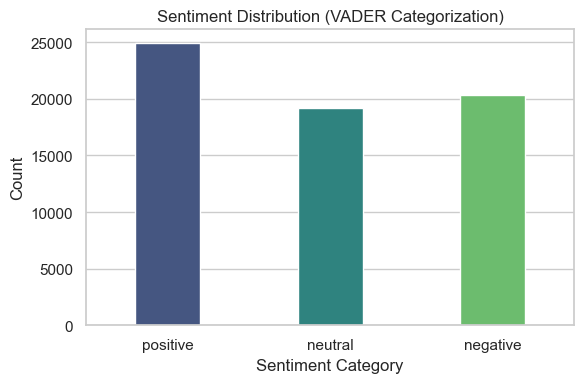

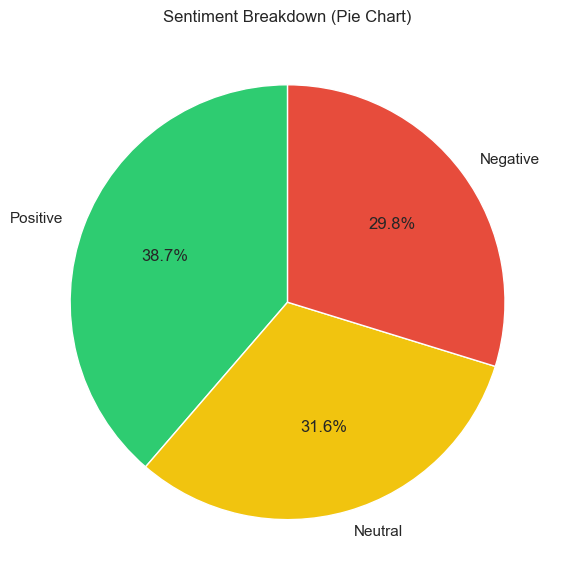

In [61]:
!pip install textblob

# Import necessary libraries
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load the previously processed data
try:
    df = pd.read_csv('processed_finance_reddit_data.csv')
    print(f"Successfully loaded data with {len(df)} rows")
except FileNotFoundError:
    print("Error: Could not find processed_finance_reddit_data.csv")
    # If the file doesn't exist, you might want to load your original data
    # and perform the preprocessing steps first
    # df = pd.read_csv('finance_reddit_data.csv')
    # ... preprocessing code here ...

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# TextBlob sentiment
def get_textblob_sentiment(text):
    if isinstance(text, str):
        try:
            return TextBlob(text).sentiment.polarity
        except:
            print(f"Error processing text with TextBlob: {text[:50]}...")
            return 0
    return 0

# VADER sentiment
def get_vader_sentiment(text):
    if isinstance(text, str):
        try:
            return sia.polarity_scores(text)
        except:
            print(f"Error processing text with VADER: {text[:50]}...")
            return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Apply sentiment analysis with error handling
print("Calculating TextBlob sentiment...")
df['textblob_sentiment'] = df['clean_text'].apply(get_textblob_sentiment)

print("Calculating VADER sentiment...")
df['vader_sentiment'] = df['clean_text'].apply(get_vader_sentiment)
df['vader_compound'] = df['vader_sentiment'].apply(lambda x: x['compound'])

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['vader_compound'].apply(categorize_sentiment)

# Add sentiment distribution
sentiment_counts = df['sentiment_category'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)
print(f"Positive: {sentiment_counts.get('positive', 0) / len(df):.2%}")
print(f"Neutral: {sentiment_counts.get('neutral', 0) / len(df):.2%}")
print(f"Negative: {sentiment_counts.get('negative', 0) / len(df):.2%}")

# Calculate sentiment averages
print("\nAverage Sentiment Scores:")
print(f"TextBlob Average: {df['textblob_sentiment'].mean():.4f}")
print(f"VADER Compound Average: {df['vader_compound'].mean():.4f}")

# Save sentiment data
df.to_csv('sentiment_finance_reddit_data.csv', index=False)
print(f"\nData saved to 'sentiment_finance_reddit_data.csv' with {len(df)} rows")

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure visual style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(6, 4))

# --- Bar Chart ---
sns.countplot(
    x='sentiment_category',
    data=df,
    palette='viridis',
    order=['positive', 'neutral', 'negative'],
    width=0.4
)

plt.title('Sentiment Distribution (VADER Categorization)')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# --- Pie Chart of Sentiment Distribution ---
plt.figure(figsize=(6, 6))
df['sentiment_category'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#2ecc71','#f1c40f','#e74c3c'], 
    labels=['Positive','Neutral','Negative']
)
plt.title('Sentiment Breakdown (Pie Chart)')
plt.ylabel('')
plt.tight_layout()
plt.show()

### Further Data Analysis

# Finance Data Analysis Visualizations

Found 4 visualizations in the 'finance_visualizations' directory.

## Word Analysis

### Common Words

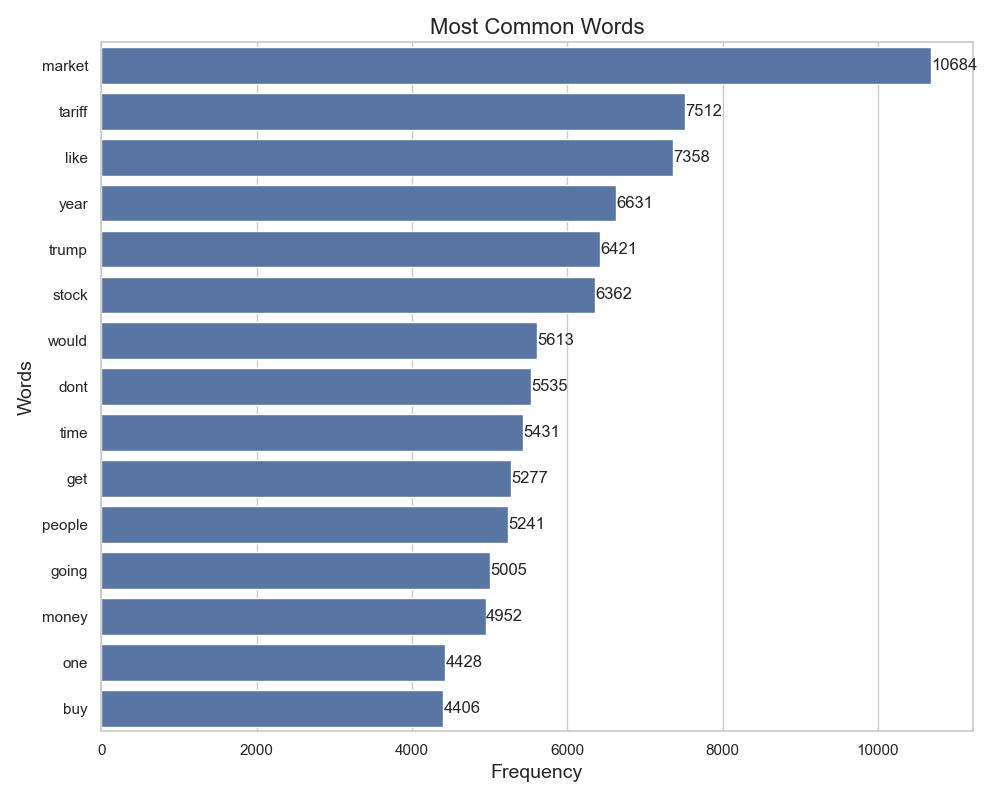

---

### Wordcloud

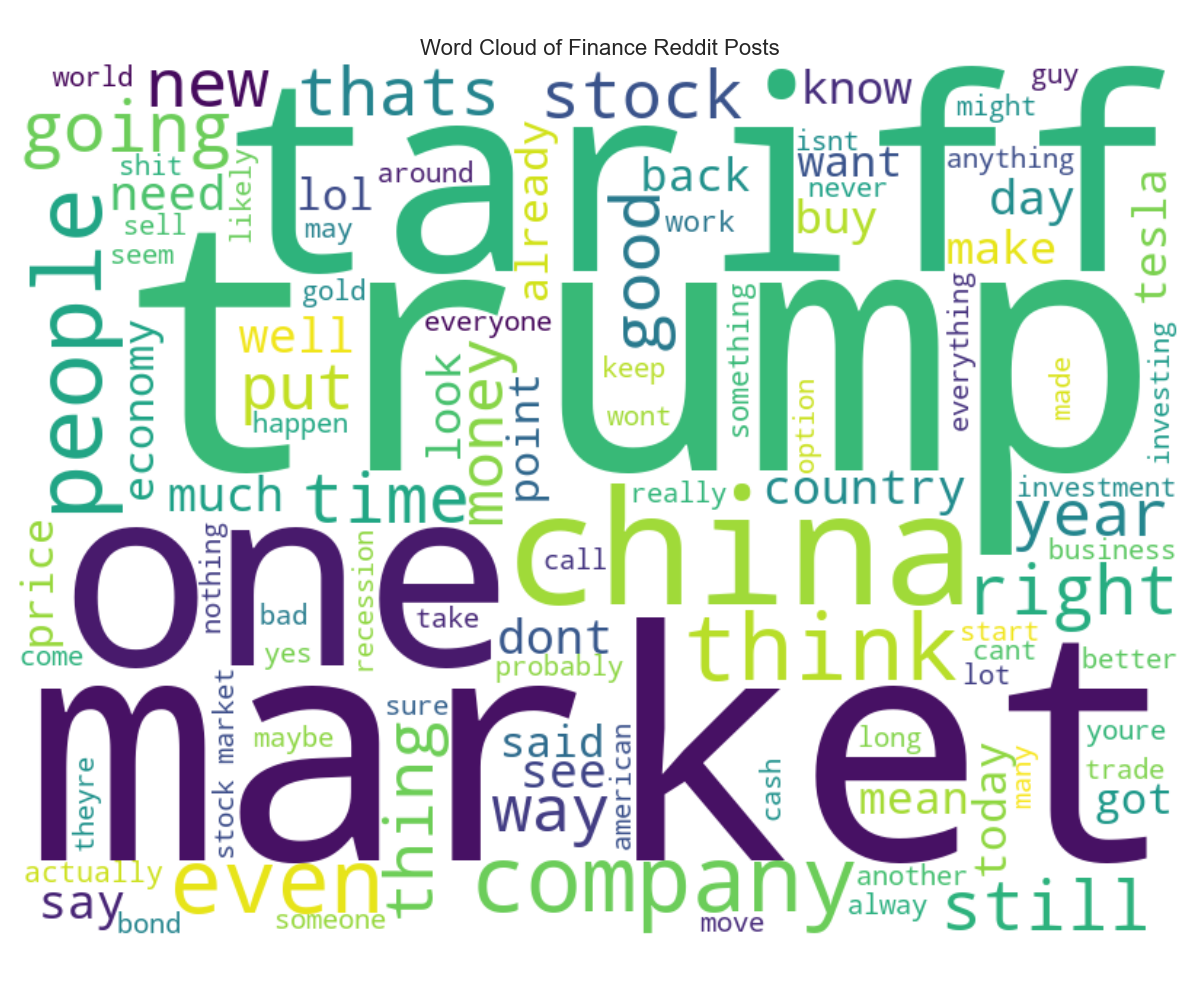

---

## Network Analysis

### Hashtag Network

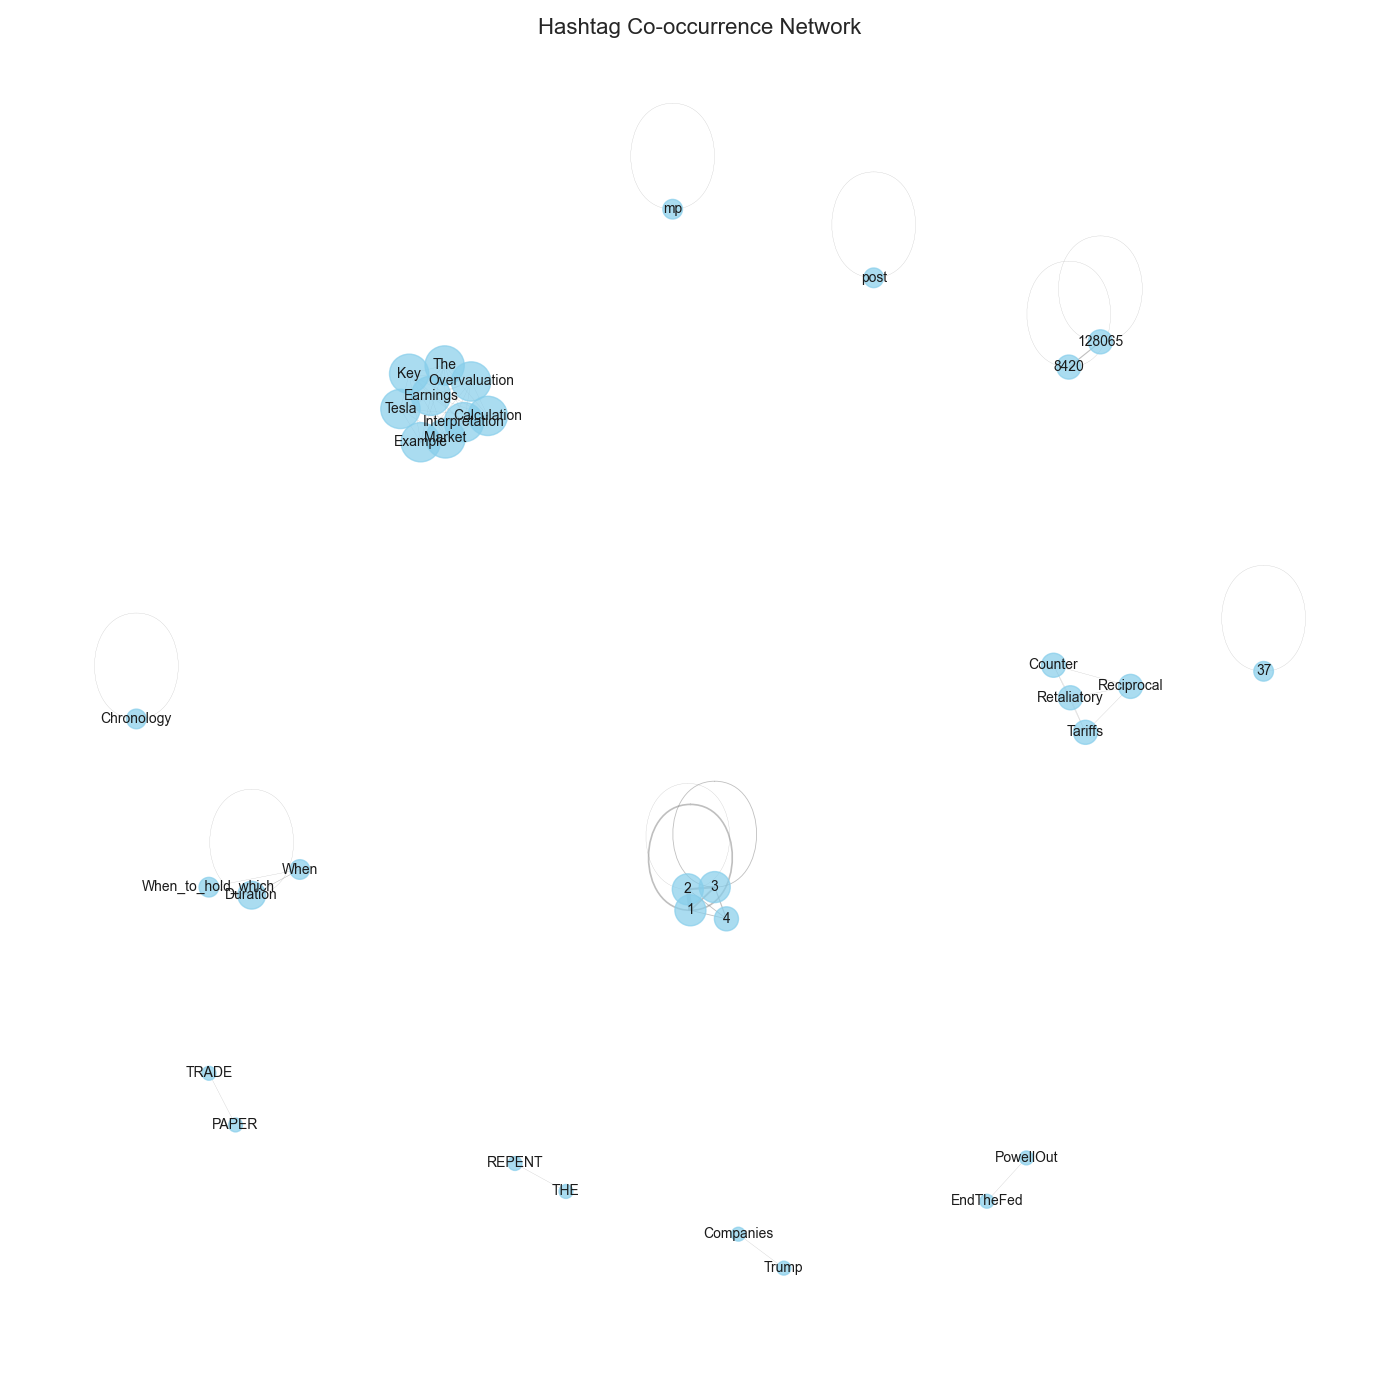

---

## Correlation Analysis

### Correlation Heatmap

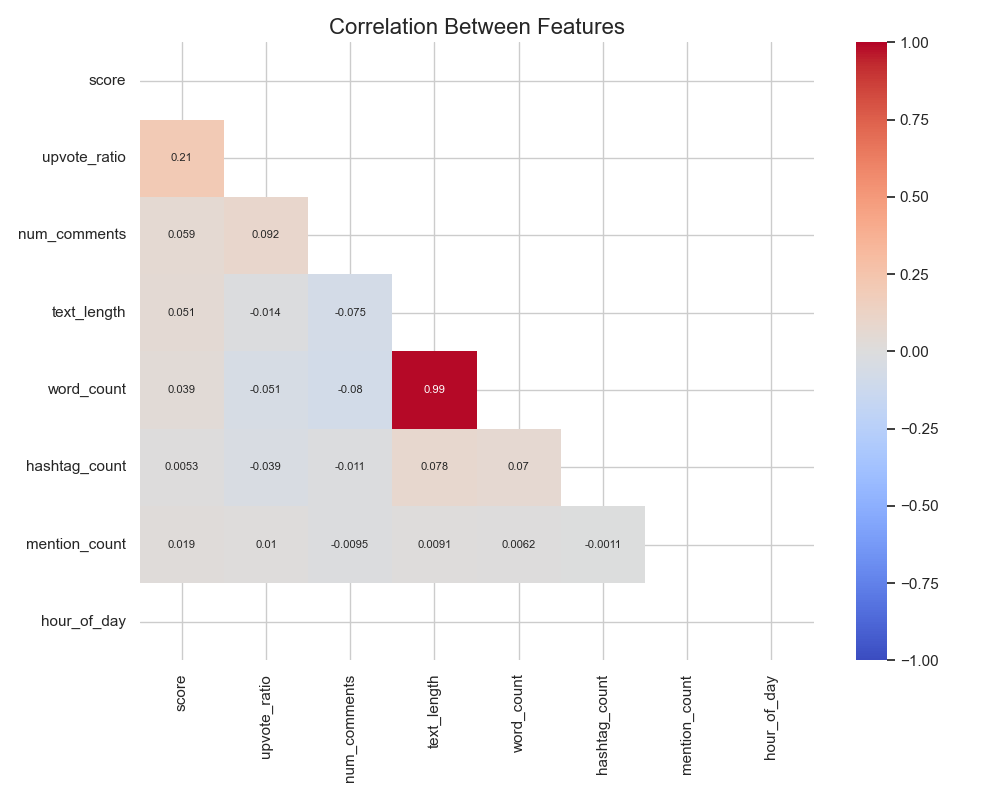

---

In [62]:
# Import required libraries
import matplotlib.pyplot as plt
import os
from IPython.display import display, Markdown, Image
import glob
from PIL import Image as PILImage
import numpy as np

# Define the visualizations directory
viz_dir = 'finance_visualizations'

# Check if directory exists
if not os.path.exists(viz_dir):
    display(Markdown("## ⚠️ Visualization directory not found!"))
    display(Markdown("Please run your visualization code first to generate plots in the 'finance_visualizations' folder."))
else:
    # Get all PNG files in the directory
    viz_files = glob.glob(f"{viz_dir}/*.png")
    
    if not viz_files:
        display(Markdown("## ⚠️ No visualizations found!"))
        display(Markdown("The directory exists but no PNG files were found. Please run your visualization code first."))
    else:
        # Sort files by name to ensure consistent display order
        viz_files.sort()
        
        # Display a header
        display(Markdown("# Finance Data Analysis Visualizations"))
        display(Markdown(f"Found {len(viz_files)} visualizations in the '{viz_dir}' directory."))
        
        # Function to get the image dimensions
        def get_image_dimensions(file_path):
            with PILImage.open(file_path) as img:
                return img.size  # (width, height)
        
        # Group visualizations by type
        summary_viz = [f for f in viz_files if 'summary' in f]
        sentiment_viz = [f for f in viz_files if 'sentiment' in f]
        word_viz = [f for f in viz_files if 'word' in f or 'common_words' in f]
        time_viz = [f for f in viz_files if 'time' in f or 'activity' in f]
        network_viz = [f for f in viz_files if 'network' in f]
        correlation_viz = [f for f in viz_files if 'correlation' in f]
        engagement_viz = [f for f in viz_files if 'engagement' in f]
        
        # Other visualizations
        other_viz = [f for f in viz_files if f not in summary_viz + sentiment_viz + word_viz + 
                     time_viz + network_viz + correlation_viz + engagement_viz]
        
        # Display summary visualizations first if available
        if summary_viz:
            display(Markdown("## Summary Visualizations"))
            for viz in summary_viz:
                width, height = get_image_dimensions(viz)
                # Calculate display width (maintain aspect ratio but limit max width)
                display_width = min(1000, width)
                display(Markdown(f"### {os.path.basename(viz).replace('_', ' ').replace('.png', '').title()}"))
                display(Image(filename=viz, width=display_width))
                display(Markdown("---"))
        
        # Display sentiment visualizations
        if sentiment_viz:
            display(Markdown("## Sentiment Analysis"))
            for viz in sentiment_viz:
                width, height = get_image_dimensions(viz)
                display_width = min(800, width)
                display(Markdown(f"### {os.path.basename(viz).replace('_', ' ').replace('.png', '').title()}"))
                display(Image(filename=viz, width=display_width))
                display(Markdown("---"))
        
        # Display word-related visualizations
        if word_viz:
            display(Markdown("## Word Analysis"))
            for viz in word_viz:
                width, height = get_image_dimensions(viz)
                display_width = min(800, width)
                display(Markdown(f"### {os.path.basename(viz).replace('_', ' ').replace('.png', '').title()}"))
                display(Image(filename=viz, width=display_width))
                display(Markdown("---"))
        
        # Display time series visualizations
        if time_viz:
            display(Markdown("## Temporal Analysis"))
            for viz in time_viz:
                width, height = get_image_dimensions(viz)
                display_width = min(900, width)
                display(Markdown(f"### {os.path.basename(viz).replace('_', ' ').replace('.png', '').title()}"))
                display(Image(filename=viz, width=display_width))
                display(Markdown("---"))
        
        # Display network visualizations (typically larger)
        if network_viz:
            display(Markdown("## Network Analysis"))
            for viz in network_viz:
                width, height = get_image_dimensions(viz)
                display_width = min(1000, width)  # Allow larger display for networks
                display(Markdown(f"### {os.path.basename(viz).replace('_', ' ').replace('.png', '').title()}"))
                display(Image(filename=viz, width=display_width))
                display(Markdown("---"))
        
        # Display correlation visualizations
        if correlation_viz:
            display(Markdown("## Correlation Analysis"))
            for viz in correlation_viz:
                width, height = get_image_dimensions(viz)
                display_width = min(900, width)
                display(Markdown(f"### {os.path.basename(viz).replace('_', ' ').replace('.png', '').title()}"))
                display(Image(filename=viz, width=display_width))
                display(Markdown("---"))
        
        # Display engagement visualizations
        if engagement_viz:
            display(Markdown("## Engagement Analysis"))
            for viz in engagement_viz:
                width, height = get_image_dimensions(viz)
                display_width = min(800, width)
                display(Markdown(f"### {os.path.basename(viz).replace('_', ' ').replace('.png', '').title()}"))
                display(Image(filename=viz, width=display_width))
                display(Markdown("---"))
        
        # Display any other visualizations
        if other_viz:
            display(Markdown("## Additional Visualizations"))
            for viz in other_viz:
                width, height = get_image_dimensions(viz)
                display_width = min(800, width)
                display(Markdown(f"### {os.path.basename(viz).replace('_', ' ').replace('.png', '').title()}"))
                display(Image(filename=viz, width=display_width))
                display(Markdown("---"))